In [600]:
from __future__ import print_function
import sys,os,datetime
import cv2 as cv
import cv2 as cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
import sklearn.metrics as skm
import csv

In [601]:
print('openCV',cv.__version__)
print('numpy',np.__version__)

openCV 3.2.0
numpy 1.13.3


In [630]:
dirTrain1 = '../Data/train/train/level-1'
dirTrain2 = '../Data/train/train/level-2'
dirTrain3 = '../Data/train/train/level-3'
dirTrain  = dirTrain2
dirDev    = '../Data/dev/dev'

In [631]:
def NNTrain(dirTrain) :
    listTrain= os.listdir(dirTrain); len(listTrain); listTrain[:12]
    listTrainNN = []
    for ff in listTrain :
        if ff.lower().endswith('.txt') : listTrainNN.append(ff.split('_')[0])
    return(listTrainNN)
listTrainNN = NNTrain(dirTrain)
len(listTrainNN), listTrainNN[:15]

(1495,
 ['1003',
  '1009',
  '100',
  '1012',
  '1018',
  '1021',
  '984',
  '994',
  '995',
  '997',
  '9',
  '952',
  '955',
  '956',
  '959'])

(390, 390, 3) (500, 500, 3) (390, 390) ../Data/train/train/level-1
751 302 213.09587217 36.0 489.453206012 0.140102480059


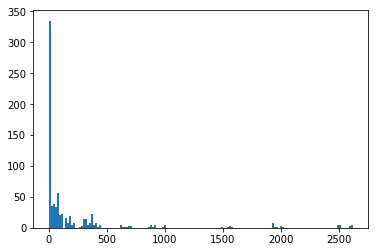

(390, 390, 3) (500, 500, 3) (390, 390) ../Data/train/train/level-2
1495 540 258.478929766 47.0 544.611454936 0.169940124764


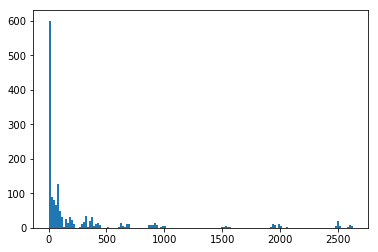

(390, 390, 3) (500, 500, 3) (390, 390) ../Data/train/train/level-3
1873 540 258.515750133 60.0 542.370915742 0.169964332764


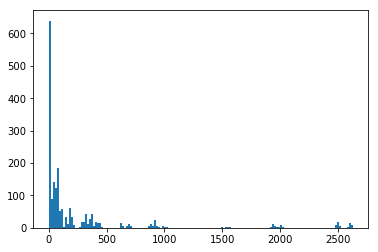

In [638]:
# Build statistics on masks
for dirTrain in (dirTrain1,dirTrain2,dirTrain3) :
    listTrainNN = NNTrain(dirTrain)
    maskSize = []
    for NN in range(len(listTrainNN)) :
        #print(NN)
        img1 = cv.imread(os.path.join(dirTrain,listTrainNN[NN]+'.tif'),-1)
        img2 = cv.imread(os.path.join(dirTrain,listTrainNN[NN]+'_ref.tif'),-1)
        img3 = cv.imread(os.path.join(dirTrain,listTrainNN[NN]+'_mask.tif'),-1)
        maskSize.append(img3[img3>0.5].size)
        #img1      = cv.GaussianBlur(img1,(3,3),0)
        #img2      = cv.GaussianBlur(img2,(3,3),0)
    print(img1.shape,img2.shape,img3.shape, dirTrain)
    
    maskSize = np.array(maskSize)
    print(len(maskSize), len(maskSize[maskSize==0]), maskSize.mean(), np.median(maskSize), maskSize.std(), maskSize.mean()/(390*390)*100.0)
    plt.hist(maskSize,bins=150); plt.show()

In [688]:
def diffPicts (img1, img2) :
    diff = []
    for cc in range(img1.shape[2]) :
        ccc   = np.abs(img1[:,:,cc]-img2[:,:,cc])
        cccL2 = np.sqrt(np.square(ccc).mean())
        cccL1 = ccc.max()
        diff.append([cccL1,cccL2,ccc])
    diffL2 = np.zeros(ccc.shape)
    for L1,L2,ccc in diff : diffL2 += np.square(ccc)
    diffL2 = np.sqrt(diffL2)
    return(diff,diffL2)

def minDeltaRC (img1,img2, ranging=range(-5,6)) :
    r0,c0 = (img2.shape[0]-img1.shape[0])/2, (img2.shape[1]-img1.shape[1])/2
    minL2 = [390*390*250.0,0,0]
    for dr in ranging :
        for dc in ranging :
            imgX2 = img2[r0+dr:r0+img1.shape[0]+dr,c0+dc:c0+img1.shape[1]+dc,:]
            diff, L2 = diffPicts(img1,imgX2)
            if (minL2[0]>L2.mean()) : minL2 = (L2.mean(),dr,dc,r0+dr,c0+dc)
            #print (dr,dc,L2.max(),L2.mean(),L2.std(),np.median(L2))
    return(minL2)

print('min=',minDeltaRC(img1,img2))

min= (11.675042985426165, 3, -2, 58, 53)


In [276]:
def computeORB (img, debug=False) :
    orb    = cv2.ORB_create();
    kp     = orb.detect(img,None)
    kp,des = orb.compute(img,kp)
    if debug :
        print (len(kp))
        print (len(des),len(des[0]),"\n",des[0],"\n",des[1])
    return kp,des

def computeMatches (des1,des2) :
    if True :
        bf      = cv2.BFMatcher(cv2.NORM_HAMMING,crossCheck=True)
        matches = bf.match(des1,des2);
        #????matches = bf.knnMatch(des1,des2,k=1);
    if False :
        index_params = dict(algorithm = 6, #cv2.FLANN_INDEX_LSH,
                            table_number = 6, 
                            key_size = 12,    
                            multi_probe_level = 1)
        search_params = dict(checks=100)
        flann   = cv2.FlannBasedMatcher(index_params,search_params)
        matchesI = flann.knnMatch(des1,des2,k=3);
        matches  = [];
        for mI in matchesI :
            for m in mI : matches.append(m);
    return matches    

def drawMatches(img1,kp1,des1,img2,kp2,des2, show=False, showNN=20):
    matches = computeMatches(des1,des2);
    matches = sorted(matches,key=lambda x:x.distance)
    if  show :
        imgM    = img1.copy()
        #imgM    = cv2.drawMatches(img1,kp1,img2,kp2,matches[:20],imgM,flags=4)
        imgM    = cv2.drawMatches(img1,kp1,img2,kp2,matches[:showNN],imgM,flags=2) #4)
        #imgM    = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,imgM,flags=2) #4)
        
        plt.figure(figsize=(15,15)); plt.imshow(imgM), plt.show()
    return(matches)


In [283]:

NN=20
print(os.path.join(dirTrain,listTrainNN[NN]+'.tif'))
img1 = cv.imread(os.path.join(dirTrain,listTrainNN[NN]+'.tif'),-1)
img2 = cv.imread(os.path.join(dirTrain,listTrainNN[NN]+'_ref.tif'),-1)


../Data/train/train/level-2/3329.tif


500 500


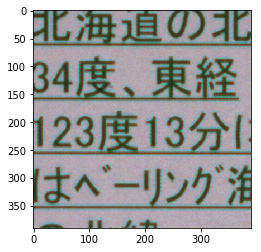

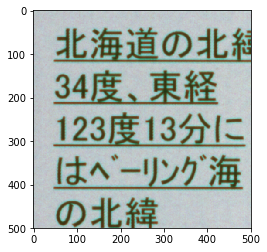

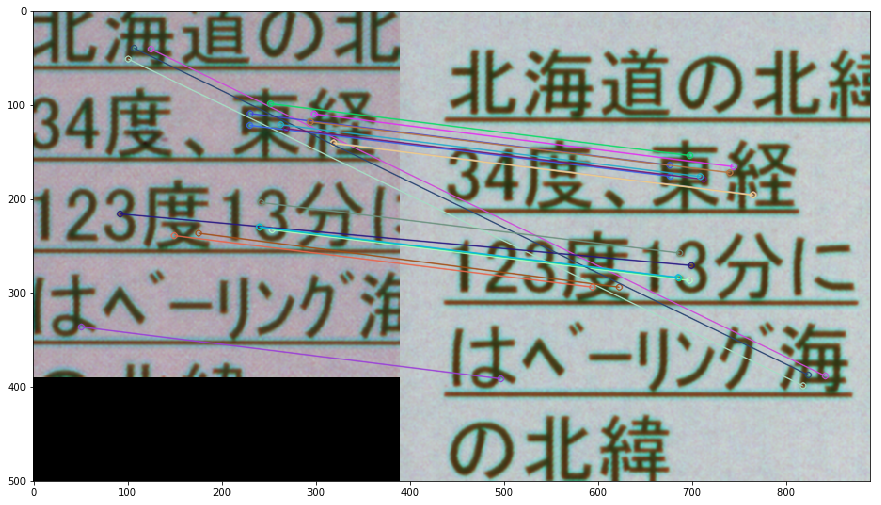

500 500 294
6.0
8.0
10.0
10.0
10.0
11.0
11.0
14.0
14.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
16.0
16.0
16.0


In [285]:
img1      = cv.GaussianBlur(img1,(3,3),0)
img2      = cv.GaussianBlur(img2,(3,3),0)
kp1, des1 = computeORB(img1)
kp2, des2 = computeORB(img2)

print(len(kp1), len(kp2))
plt.imshow(img1); plt.show()
plt.imshow(img2); plt.show()

matches = drawMatches(img1,kp1,des1, img2,kp2,des2, show=True)
#drawMatches(img2,kp2,des2, img1,kp1,des1, show=True)

print(len(kp1), len(kp2), len(matches))
for mm in matches[:20] : print(mm.distance)


In [286]:

NN=12
res = []
#print(os.path.join(dirTrain,'level-1',listTrainNN[NN]+'.tif'))
for NN in range(len(listTrainNN)) :
    #print(NN)
    img1 = cv.imread(os.path.join(dirTrain,listTrainNN[NN]+'.tif'),-1)
    img2 = cv.imread(os.path.join(dirTrain,listTrainNN[NN]+'_ref.tif'),-1)
    #img1      = cv.GaussianBlur(img1,(3,3),0)
    #img2      = cv.GaussianBlur(img2,(3,3),0)
    kp1, des1 = computeORB(img1)
    kp2, des2 = computeORB(img2)
    matches = []
    if len(kp1)>0 and len(kp2)>0 :
        matches = drawMatches(img1,kp1,des1, img2,kp2,des2, show=False)
    res.append([len(kp1),len(kp2),len(matches),
                (matches[0].distance if len(matches)>0 else -1),
                (matches[-1].distance if len(matches)>0 else -1)])


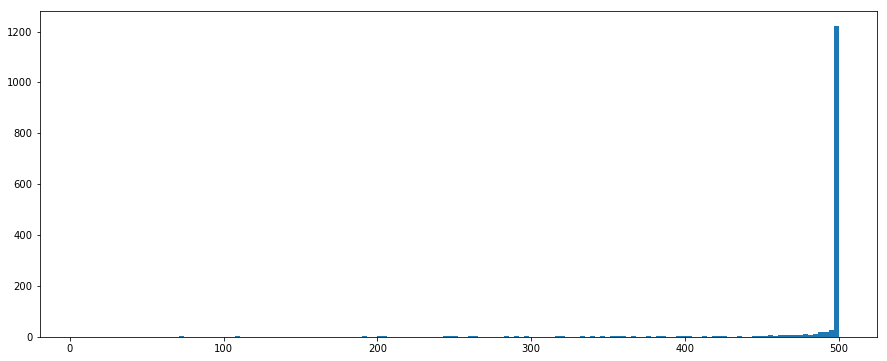

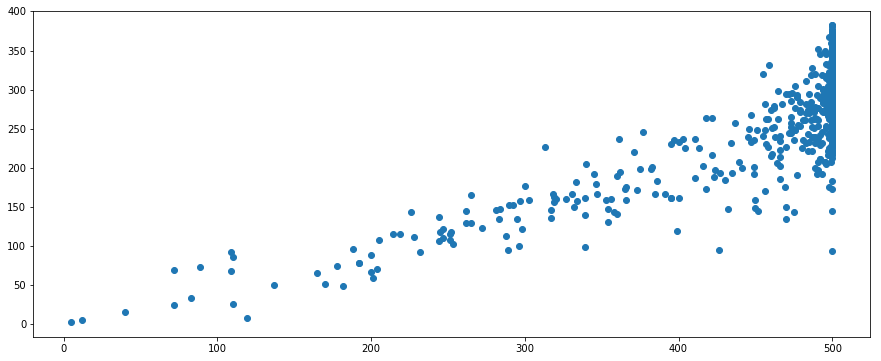

In [287]:
plt.figure(figsize=(15,6));
plt.hist([k2 for k1,k2,mm,mm0,mmM in res],bins=150); plt.show()
plt.figure(figsize=(15,6));
plt.scatter([k2 for k1,k2,mm,mm0,mmM in res],[mm for k1,k2,mm,mm0,mmM in res]); plt.show()

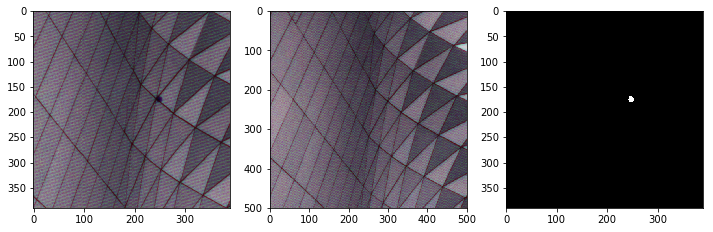

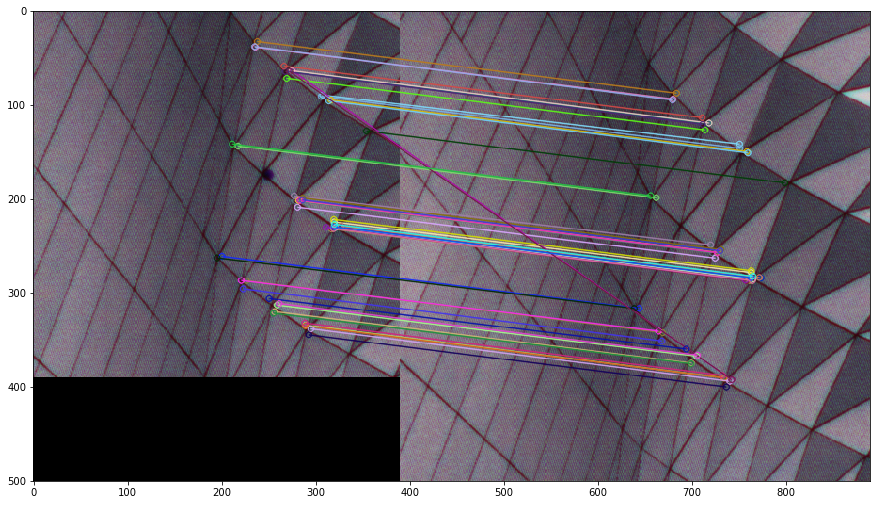

408 477 217 98.939112426 101.080892
[[[   0.    0.]]

 [[   0.  389.]]

 [[ 389.  389.]]

 [[ 389.    0.]]] [[[  55.36024475   56.29463196]]

 [[  53.8297081   444.04180908]]

 [[ 443.98348999  444.48162842]]

 [[ 442.58224487   55.49541092]]]


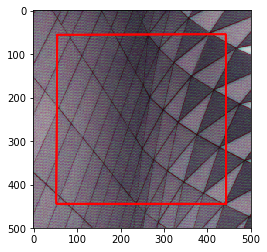

In [681]:
NN = 170
img1 = cv.imread(os.path.join(dirTrain,listTrainNN[NN]+'.tif'),-1)
img2 = cv.imread(os.path.join(dirTrain,listTrainNN[NN]+'_ref.tif'),-1)
img3 = cv.imread(os.path.join(dirTrain,listTrainNN[NN]+'_mask.tif'),-1)
#img1[:,:,1] = 0
#img2[:,:,1] = 0

#img1      = cv.GaussianBlur(img1,(3,3),0)
#img2      = cv.GaussianBlur(img2,(3,3),0)

plt.figure(figsize=(12,5))
plt.subplot(1,3,1); plt.imshow(img1);
plt.subplot(1,3,2); plt.imshow(img2);
plt.subplot(1,3,3); plt.imshow(img3,'gray'); 
plt.show()

if True :
    kp1, des1 = computeORB(img1)
    kp2, des2 = computeORB(img2)
    matches = []
    if len(kp1)>0 and len(kp2)>0 :
        matches = drawMatches(img1,kp1,des1, img2,kp2,des2, show=True, showNN=50)
        good = matches
        print(len(kp1),len(kp2),len(matches),img1[:,:,2].mean(),img2[:,:,2].mean())
        MIN_MATCH_COUNT = 6
        if True and len(good)>MIN_MATCH_COUNT:
            src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
            matchesMask = mask.ravel().tolist()

            h,w,c = img1.shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            dst = cv2.perspectiveTransform(pts,M)
            
            print(pts,dst)

            img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
            
            plt.imshow(img2); plt.show()

        else:
            print ("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
            matchesMask = None
    else:
        print(len(kp1),len(kp2),img1[:,:,2].mean(),img2[:,:,2].mean())


In [682]:
pts[2]-pts[0]
dst

array([[[  55.36024475,   56.29463196]],

       [[  53.8297081 ,  444.04180908]],

       [[ 443.98348999,  444.48162842]],

       [[ 442.58224487,   55.49541092]]], dtype=float32)

In [713]:
img2 = cv.imread(os.path.join(dirTrain,listTrainNN[NN]+'_ref.tif'),-1)
img2X = img2[int(dst[0][0][0]-16):int(dst[2][0][0]+17),int(dst[0][0][1]-17):int(dst[2][0][1]+15),:]; img2X.shape

(421, 420, 3)

In [714]:
print('min=',minDeltaRC(img1,img2X))

min= (11.675042985426165, 4, -1, 19, 14)


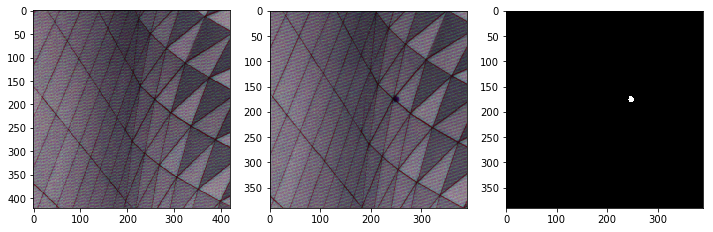

13.2026496866 
 169 180 242 253


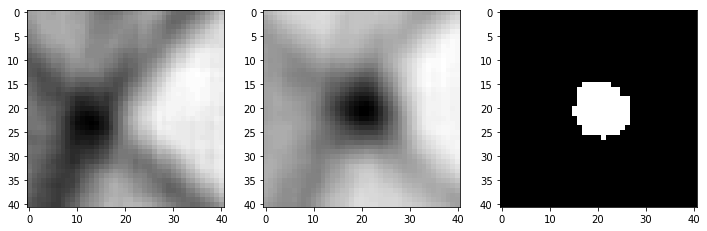

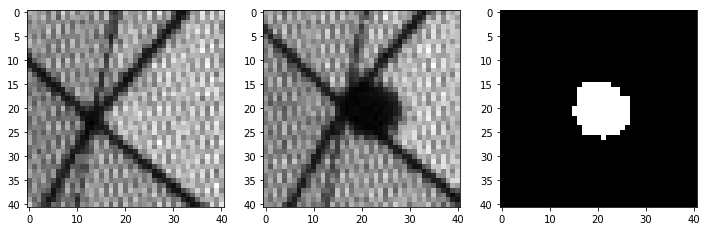

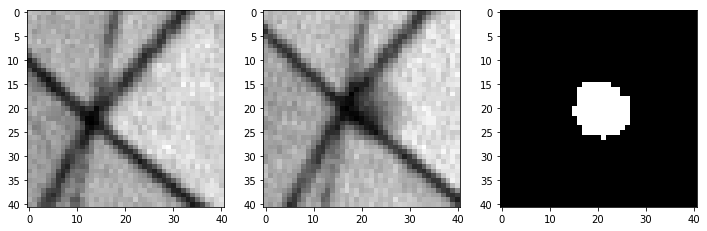

In [730]:
img2 = cv.imread(os.path.join(dirTrain,listTrainNN[NN]+'_ref.tif'),-1)
img2X = img2[int(dst[0][0][0]-16):int(dst[2][0][0]+17),int(dst[0][0][1]-17):int(dst[2][0][1]+15),:]; img2X.shape
plt.figure(figsize=(12,6))
plt.subplot(1,3,1); plt.imshow(img2X); 
plt.subplot(1,3,2); plt.imshow(img1); 
plt.subplot(1,3,3); plt.imshow(img3,'gray'); 
plt.show()

rcL2,_,_,r0,c0 = minDeltaRC(img1,img2X)
img2X = img2X[r0:r0+img1.shape[0],c0:c0+img1.shape[1]]

rcL2,_,_,r0,c0 = minDeltaRC(img1,img2,ranging=(-3,3))
img2X = img2[r0:r0+img1.shape[0],c0:c0+img1.shape[1]]



a = np.where(img3>0.5)
ar0, arL, ac0, acL = 0, img3.shape[0], 0, img3.shape[1]
if a[0].shape[0]>0 : 
    ar0, arL, ac0, acL = a[0].min(), a[0].max(), a[1].min(), a[1].max()

print(rcL2,'\n',ar0,arL,ac0,acL)

rcd = 15
ar0 = ar0-rcd if ar0>=rcd else 0
ac0 = ac0-rcd if ac0>=rcd else 0
arL = arL+rcd
acL = acL+rcd

for cc in range(img2X.shape[2]) :
    plt.figure(figsize=(12,6))
    plt.subplot(1,3,1); plt.imshow(img2X[ar0:arL,ac0:acL,cc],'gray'); 
    plt.subplot(1,3,2); plt.imshow(img1 [ar0:arL,ac0:acL,cc],'gray'); 
    plt.subplot(1,3,3); plt.imshow(img3 [ar0:arL,ac0:acL],'gray'); 
    plt.show()

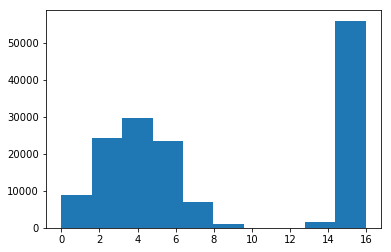

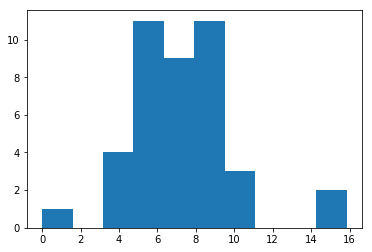

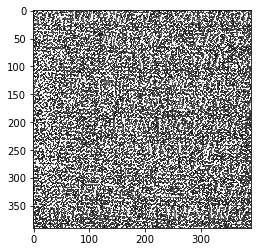

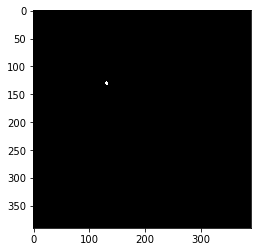

In [553]:
a = np.abs(img2X-img1)
b = np.float32(np.sqrt(a[:,:,1]^2)) #+a[:,:,1]^2)) #+a[:,:,2]^2))
#b[b<13.0] = 0.0
plt.hist(b.ravel()); plt.show()
plt.hist(b[img3>0.5].ravel()); plt.show()
#plt.imshow(b); plt.show()
#b.reshape(b.shape+(1,)).shape
plt.imshow(b,'gray'); plt.show()
plt.imshow(img3,'gray'); plt.show()
#b.dtype

-4 166.358983125 161.234678939 255


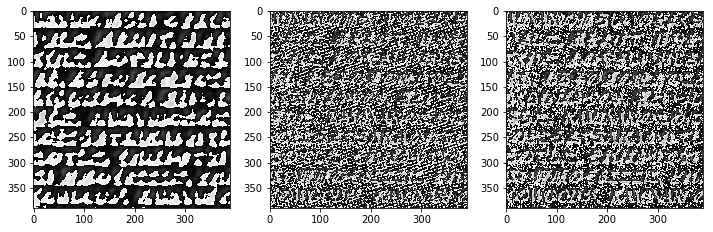

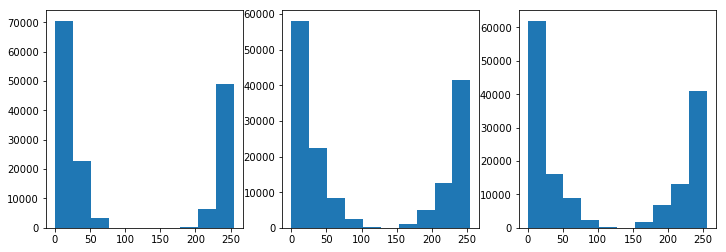

-3 166.38058295 161.234678939 255


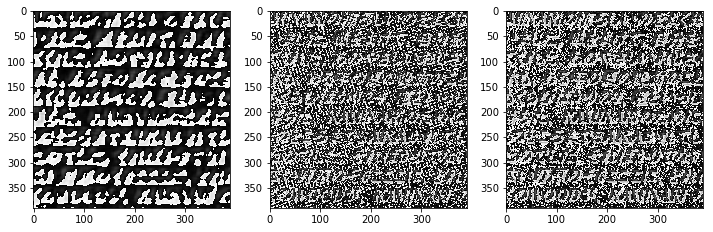

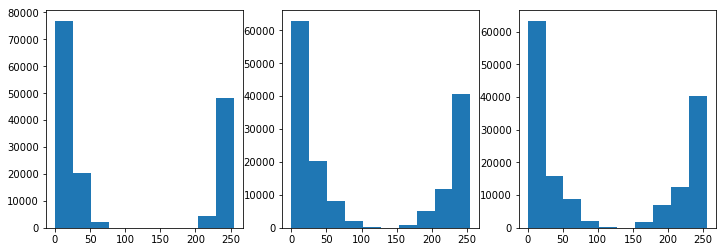

-2 166.392277011 161.234678939 255


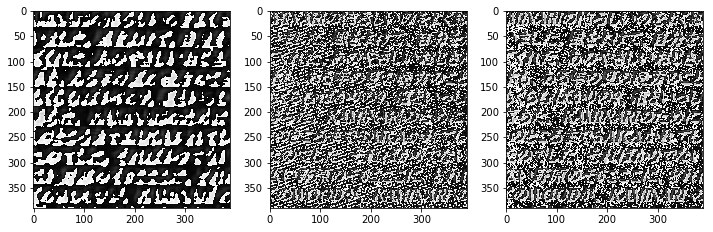

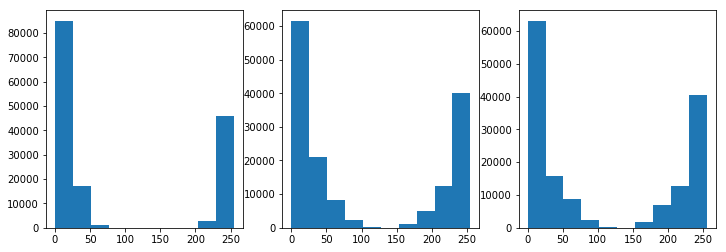

-1 166.394343634 161.234678939 255


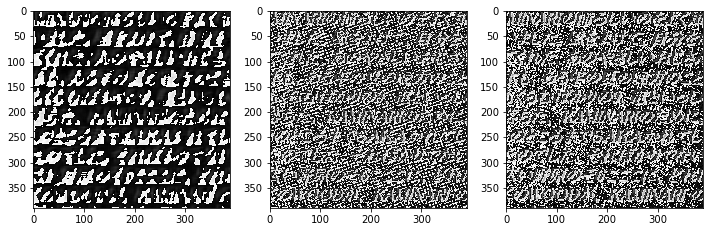

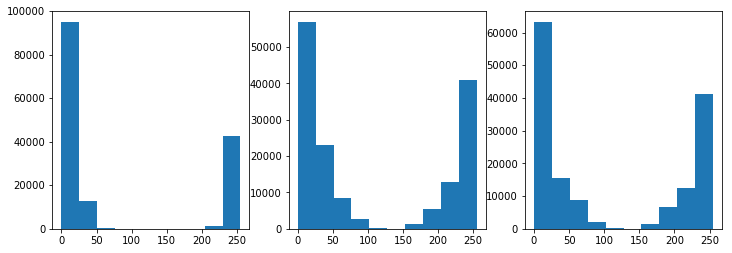

0 166.387150997 161.234678939 255


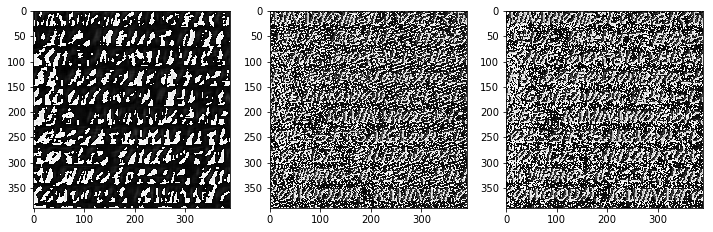

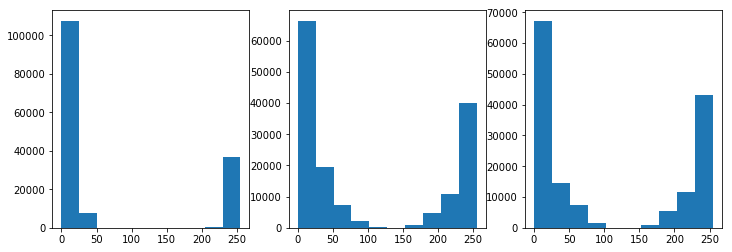

1 166.378757396 161.234678939 255


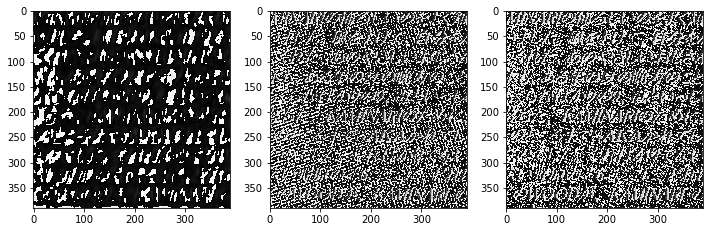

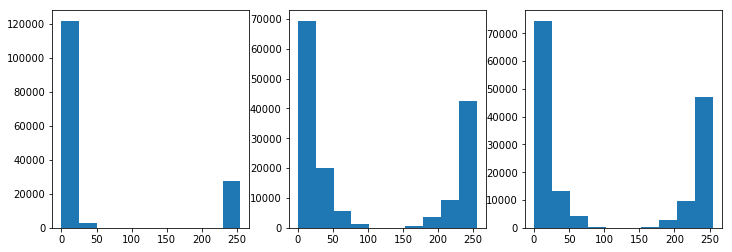

2 166.36541968 161.234678939 255


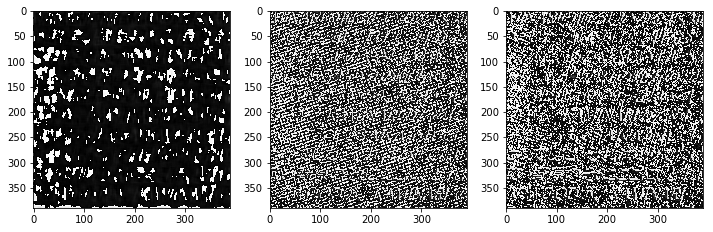

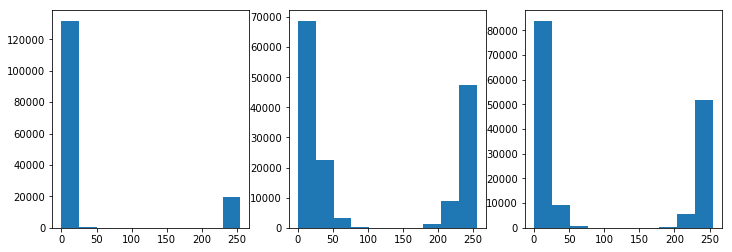

3 166.359555117 161.234678939 255


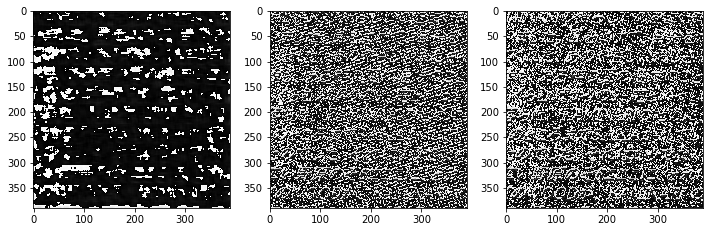

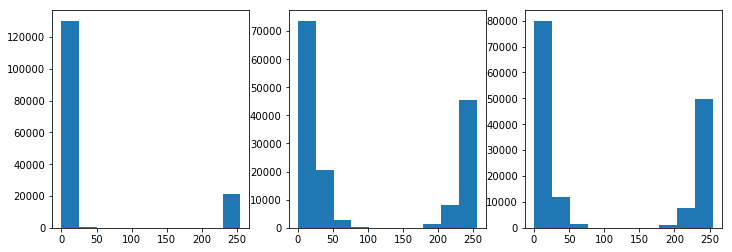

4 166.364455402 161.234678939 255


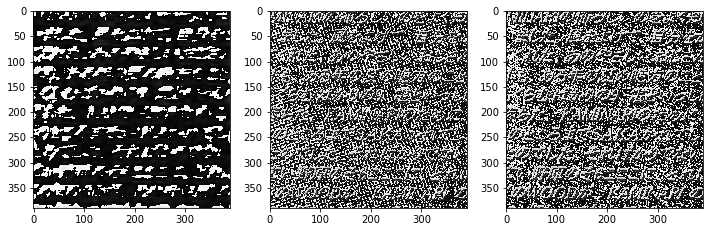

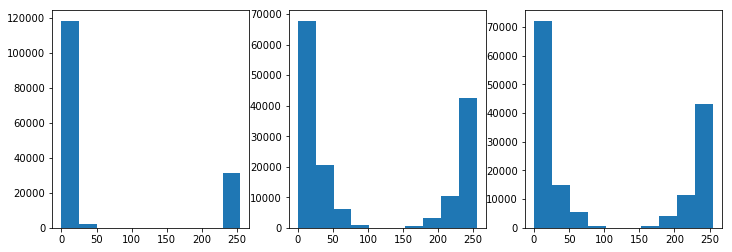

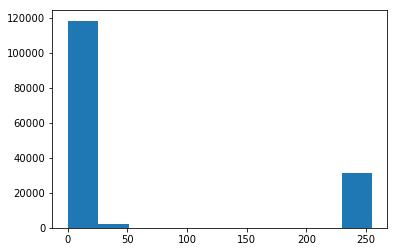

In [359]:
for dd in [-4,-3,-2,-1,0,1,2,3,4] :
    img2X = img2[int(dst[0][0][0]+dd):int(dst[2][0][0]+dd),int(dst[0][0][1]+dd):int(dst[2][0][1]+dd),:]; img2X.shape
    print(dd,img2X.mean(),img1.mean(),(img2X[:,:,0]-img1[:,:,0]).max())
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img2X[:,:,0]-img1[:,:,0],'gray'); 
    plt.subplot(1,3,2); plt.imshow(img2X[:,:,1]-img1[:,:,1],'gray'); 
    plt.subplot(1,3,3); plt.imshow(img2X[:,:,2]-img1[:,:,2],'gray'); 
    plt.show()
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.hist((img2X[:,:,0]-img1[:,:,0]).ravel()); 
    plt.subplot(1,3,2); plt.hist((img2X[:,:,1]-img1[:,:,1]).ravel()); 
    plt.subplot(1,3,3); plt.hist((img2X[:,:,2]-img1[:,:,2]).ravel()); 
    plt.show()
plt.hist((img2X[:,:,0]-img1[:,:,0]).ravel()); plt.show()

In [368]:
kp1[1].pt,kp1[1].size,kp1[1].response,kp1[1].octave,kp1[1].angle,

((118.0, 208.0), 31.0, 6.922763714101166e-05, 0, 181.3831329345703)

In [373]:
matches[1].queryIdx, matches[1].trainIdx, matches[1].distance

(450, 448, 17.0)

In [428]:
x, y = [], []
for mm in matches :
    #print(mm.queryIdx,int(kp1[mm.queryIdx].pt[0]))
    p1 = img1[int(kp1[mm.queryIdx].pt[0]),int(kp1[int(mm.queryIdx)].pt[1])]
    p2 = img2[int(kp2[mm.trainIdx].pt[0]),int(kp2[mm.trainIdx].pt[1]),:]
    #print(p1,p2)
    x.append(p1)
    y.append(p2)


In [429]:
xx, yy = np.array(x), np.array(y)
xx.shape

(300, 3)

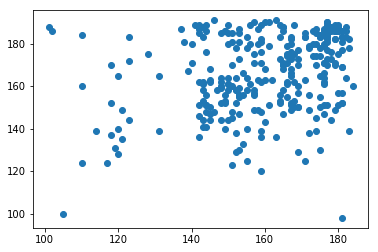

In [430]:
plt.scatter(xx[:,0],yy[:,0]); plt.show()

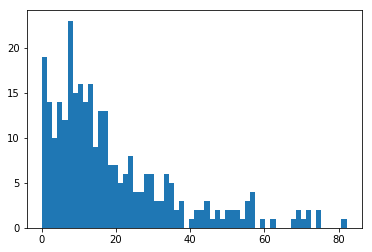

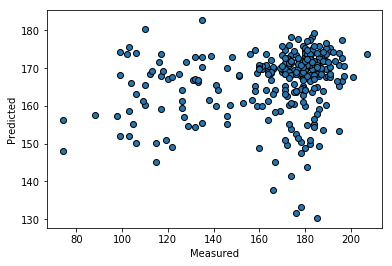

(300, 3) (198, 3)


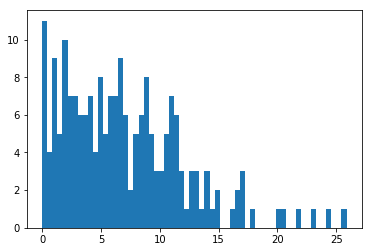

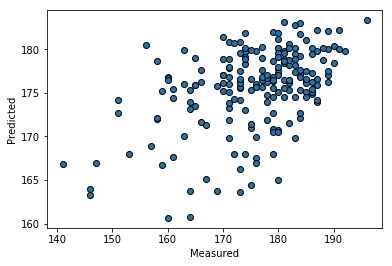

In [458]:
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.svm import SVR

lr = linear_model.LinearRegression()
#lr = SVR(kernel='linear') #, C=1e3)
#lr = SVR(kernel='rbf') #, C=1e3)
#lr = SVR(kernel='poly') #, C=1e3)

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
xxx = xx.copy()
yyy = yy[:,2].copy()
predicted = cross_val_predict(lr, xxx, yyy, cv=10)
#predicted = lr.fit(xxx, yyy).predict(xxx)
plt.hist(np.abs(predicted-yyy),bins=60); plt.show()
#print(predicted,yyy)

fig, ax = plt.subplots()
ax.scatter(yyy, predicted, edgecolors=(0, 0, 0))
#ax.plot([yyy.min(), yyy.max()], [yyy.min(), yyy.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()


xy = np.abs(predicted-yyy)<=20.0
xxxn, yyyn = xx[xy], yyy[xy]
xxx = xxxn
yyy = yyyn
print(xx.shape,xxxn.shape)

#predicted = cross_val_predict(lr, xxx, yyy, cv=10)
lrfit = lr.fit(xxx, yyy)
predicted = lr.predict(xxx)
plt.hist(np.abs(predicted-yyy),bins=60); plt.show()

fig, ax = plt.subplots()
ax.scatter(yyy, predicted, edgecolors=(0, 0, 0))
#ax.plot([yyy.min(), yyy.max()], [yyy.min(), yyy.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [479]:
#img2L = np.array(img2L); img2L.shape